<h1 align=center><font size = 5>Part 2: Data Collection</font></h1>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import warnings
warnings.filterwarnings('ignore')

# library to handle data in a vectorized manner
import numpy as np 

# library for data analsysis
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 

# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 

# library to handle requests
import requests 

# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize 

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
import matplotlib.pyplot as plt

# map rendering library
import folium 

from urllib.request import urlopen
from bs4 import BeautifulSoup

print('Libraries imported.')


Bad key "text.kerning_factor" on line 4 in
C:\Users\sumai\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


Libraries imported.


### Dataset 1: Webscrape the Wikipedia data using BeautifulSoup

Source: https://en.wikipedia.org/wiki/List_of_districts_of_Bangladesh

Bangladesh has a total of 8 divisions and 64 districts. In order to segment the districts and explore them, we will essentially need a dataset that contains the 8 divisions and the 64 districts that exist in each division as well as the the latitude and longitude coordinates of each district. 

In [2]:
# url that we are scraping
url = 'https://en.wikipedia.org/wiki/List_of_districts_of_Bangladesh'

# this is the html from the given url
html = urlopen(url)

soup = BeautifulSoup(html)

# skip the first 1 header rows
data_rows = soup.findAll('tr')[1:]  

bangladesh_data = [[td.getText() for td in data_rows[i].findAll('td')] for i in range(len(data_rows))]

# Let's check if we're getting the data points correctly
print (bangladesh_data[12])

# create an empty list to hold all the data
bangladesh_data_02 = []  

# for each table row
for i in range(len(data_rows)):
    # create an empty list for each row
    bangladesh_row = []  

    # for each table data element from each table row
    for td in data_rows[i].findAll('td'):        
        # get the text content and append to the player_row 
        bangladesh_row.append(td.getText())        

    # then append each pick/player to the player_data matrix
    bangladesh_data_02.append(bangladesh_row)
    
bangladesh_data == bangladesh_data_02

['Barguna District', 'বরগুনা', 'Barisal', '1984', '892', '1939\n']


True

### Clean the Scraped Data

In [3]:
df_Bangladesh = pd.DataFrame(bangladesh_data)
df_Bangladesh.reset_index(inplace = True)
del df_Bangladesh['index']

df_Bangladesh.columns = ['District', 'Bengali Names', 'Division', 'Year Established','Population', 'Area', 'N']
df_Bangladesh.drop (['Bengali Names', 'Year Established', 'Area', 'N'], axis= 1, inplace = True) 

df_Bangladesh = df_Bangladesh[['Division', 'District', 'Population']]
df_Bangladesh.dropna(axis = 1)
df_Bangladesh = df_Bangladesh.iloc[12:]
df_Bangladesh = df_Bangladesh.iloc[:-35]
df_Bangladesh = df_Bangladesh.reset_index(drop = True)

df_Bangladesh["Population"] = pd.to_numeric(df_Bangladesh["Population"])
# the population given as a multiple of 1000
df_Bangladesh ['Population'] = df_Bangladesh ['Population'] * 1000
df_Bangladesh.tail()

,Division,District,Population
59,Rangpur,Thakurgaon District,1380000
60,Sylhet,Habiganj District,2059000
61,Sylhet,Moulvibazar District,1902000
62,Sylhet,Sunamganj District,2443000
63,Sylhet,Sylhet District,5316000


In [4]:
df_Bangladesh.shape

(64, 3)

### Collect the latitude and longitude values for **dataset 1** using **geopy**

There are similarities in names of the districts of Bangladesh with some other parts of the world. So we have to make a few changes in the names of the Districts manually to import the correct Coordinates using Geopy.

In [5]:
df_Bangladesh.loc[3, 'District'] = "Gopalganj BD"
df_Bangladesh.loc[1, 'District'] = "Faridpur BD"
df_Bangladesh.loc[2, 'District'] = "Gazipur BD"
df_Bangladesh.loc[4, 'District'] = "Kishoreganj BD"
df_Bangladesh.loc[5, 'District'] = "Madaripur BD"

In order to define an instance of the geocoder, we need to define a user_agent. We will name our agent <em>Bangladesh</em>, as shown below.

In [6]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="Bangladesh")
df_Bangladesh['Latitude'] = df_Bangladesh['District'].apply(geolocator.geocode).apply(lambda x: (x.latitude))
df_Bangladesh['Longitude'] = df_Bangladesh['District'].apply(geolocator.geocode).apply(lambda x: (x.longitude))

df_Bangladesh[['District','Dis']] = df_Bangladesh.District.str.split(" ", n = 1, expand=True)
del df_Bangladesh['Dis']
df_Bangladesh.loc[11, 'District'] = "Cox's Bazar"
df_Bangladesh.head()

,Division,District,Population,Latitude,Longitude
0,Barisal,Barguna,892000,22.157833,90.129495
1,Barisal,Faridpur,2415000,23.604018,89.841554
2,Barisal,Gazipur,1946000,23.998080,90.422985
3,Barisal,Gopalganj,710000,23.005942,89.826348
4,Barisal,Kishoreganj,1596000,25.899303,89.016922


In [7]:
print (df_Bangladesh.shape)
df_Bangladesh.dtypes

(64, 5)


Division       object
District       object
Population      int64
Latitude      float64
Longitude     float64
dtype: object

AWESOME! Looks good so far!

In [8]:
print('The dataframe has {} divisions and {} districts.'.format(len(df_Bangladesh['Division'].unique()), df_Bangladesh.shape[0]))

The dataframe has 8 divisions and 64 districts.


#### We will consider the data points for Dhaka division only. 

In [9]:
dhk = df_Bangladesh[df_Bangladesh['Division'] == 'Dhaka'].reset_index(drop = True)
print (dhk.shape)
dhk.to_csv('dhk.csv')
dhk.head(13)

(13, 5)


,Division,District,Population,Latitude,Longitude
0,Dhaka,Dhaka,12518000,23.779815,90.361782
1,Dhaka,Faridpur,1989000,23.464922,89.861945
2,Dhaka,Gazipur,3548000,24.105045,90.464526
3,Dhaka,Gopalganj,1218000,23.103493,89.907841
4,Dhaka,Kishoreganj,3029000,24.340814,90.927683
5,Dhaka,Madaripur,1212000,23.234011,90.144608
6,Dhaka,Manikganj,1447000,23.871163,89.998783
7,Dhaka,Munshiganj,1503000,23.548380,90.534972
8,Dhaka,Narayanganj,3074000,23.623811,90.499966
9,Dhaka,Narsingdi,2315000,24.023833,90.816348


In [10]:
print('The dataframe has {} divisions and {} districts.'.format(len(dhk['Division'].unique()), dhk.shape[0]))

The dataframe has 1 divisions and 13 districts.


#### Use geopy library to get the latitude and longitude values of Bangladesh

In [11]:
address = 'Dhaka Bangladesh'

geolocator = Nominatim(user_agent="Bangladesh_explorer")
location = geolocator.geocode(address)
latitude_bd = location.latitude
longitude_bd = location.longitude
print('The geograpical coordinate of Bangladesh are {}, {}.'.format(latitude_bd, longitude_bd))

The geograpical coordinate of Bangladesh are 23.810651, 90.4126466.


#### Create a map of Bangldesh with 64 districts superimposed on top

In [12]:
# create map of New York using latitude and longitude values
map_dhaka = folium.Map(location=[latitude_bd, longitude_bd], zoom_start=8)

# add markers to map
for lat, lng, div, dis in zip(dhk['Latitude'], dhk['Longitude'], dhk['Division'], dhk['District']):
    label = '{}, {}'.format(dis, div)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='gray',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dhaka)  
    
map_dhaka

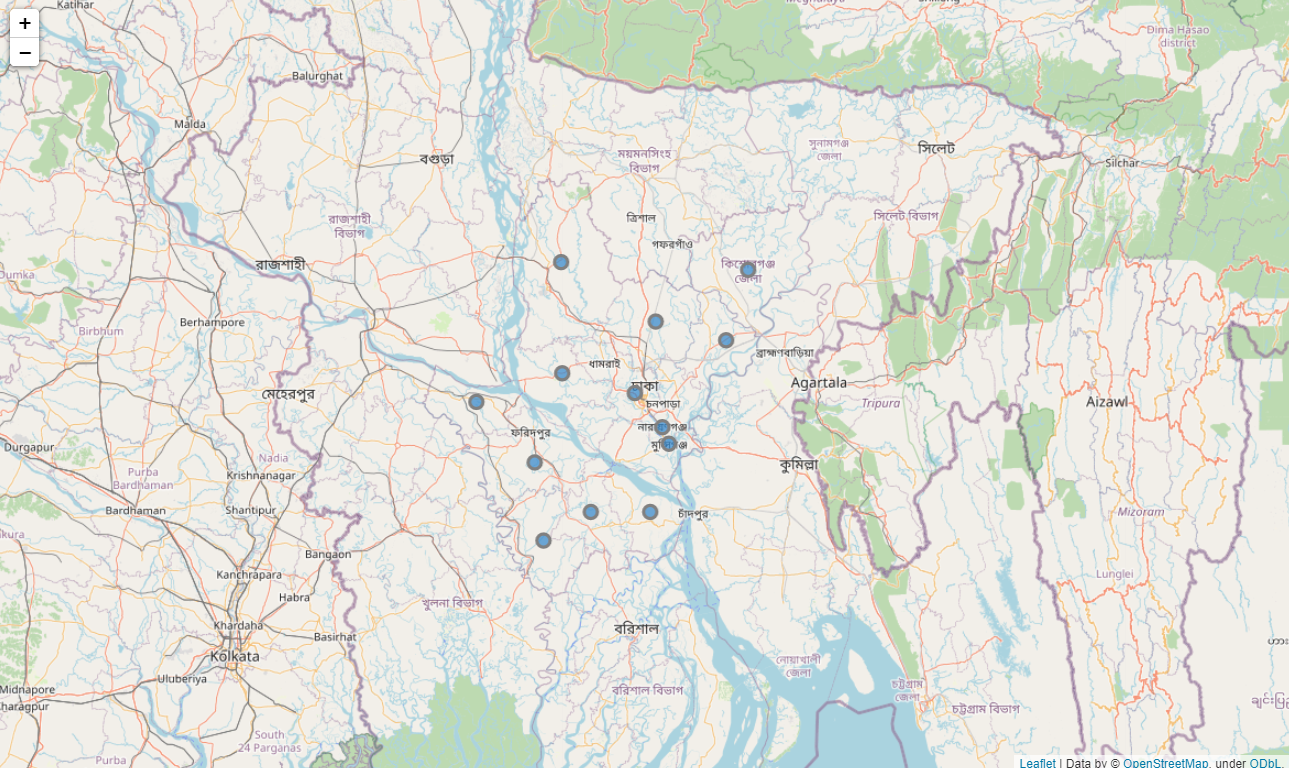

In [13]:
## here's the screenshot as Github doesn't render folium map 

from IPython.display import Image
Image("Image/map_dhaka.png")

### Utilize Foursquare API for Venues in Dhaka (**Dataset 1**)

#### Define Foursquare Credentials and Version

In [14]:
CLIENT_ID = '0OIOAMV3MQX4QYSSVYLHCR0MEFPKQTZQ4SS0MH2VZNGJMPWG' # your Foursquare ID
CLIENT_SECRET = 'AQVTXDL3BAYH3ZFXZ1GOYD5CSKIP24J5NRPRC31UUK4Z0TEO' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 0OIOAMV3MQX4QYSSVYLHCR0MEFPKQTZQ4SS0MH2VZNGJMPWG
CLIENT_SECRET:AQVTXDL3BAYH3ZFXZ1GOYD5CSKIP24J5NRPRC31UUK4Z0TEO


#### Let's create a function to repeat the same process to all the districts in Dhaka

In [15]:
LIMIT = 500

def getNearbyVenues(div, names, latitudes, longitudes, radius=8000):
    
    venues_list=[]
    for div, name, lat, lng in zip(div, names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            div, 
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Division',
                  'District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each district and create a new dataframe called *bangladesh_venues*.

In [16]:
# type your answer here

dhaka_venues = getNearbyVenues(div= dhk['Division'], 
                                   names= dhk['District'],
                                   latitudes= dhk['Latitude'],
                                   longitudes= dhk['Longitude']
                                  )



Dhaka
Faridpur
Gazipur
Gopalganj
Kishoreganj
Madaripur
Manikganj
Munshiganj
Narayanganj
Narsingdi
Rajbari
Shariatpur
Tangail


#### Let's check the size of the resulting dataframe

In [17]:
print(dhaka_venues.shape)

(129, 8)


### The complete Dataset 1 looks like bellow-- 

In [18]:
dhaka_venues.head()

,Division,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Dhaka,Dhaka,23.779815,90.361782,BCS Computer City,23.778736,90.379514,Electronics Store
1,Dhaka,Dhaka,23.779815,90.361782,Sher-e-Bangla National Cricket Stadium,23.806196,90.363579,Cricket Ground
2,Dhaka,Dhaka,23.779815,90.361782,Russel Square (রাসেল স্কয়ার),23.751312,90.378463,Plaza
3,Dhaka,Dhaka,23.779815,90.361782,"Gloria Jeans Coffees, Dhanmondi",23.749863,90.368709,Coffee Shop
4,Dhaka,Dhaka,23.779815,90.361782,Nando's,23.753045,90.369766,Portuguese Restaurant


In [19]:
dhaka_venues.to_csv('dhaka_venues.csv')

### Dataset 2:  Webscrape using BeautifulSoup

Source: http://en.banglapedia.org/index.php?title=Dhaka_District

In [20]:
# url that we are scraping
url = 'http://en.banglapedia.org/index.php?title=Dhaka_District'

# this is the html from the given url
html = urlopen(url)

soup = BeautifulSoup(html)

# skip the first 1 header rows
data_rows2 = soup.findAll('tr')[5:]  

bangladesh_data2 = [[td.getText() for td in data_rows2[i].findAll('td')]
            for i in range(len(data_rows2))]

# create an empty list to hold all the data
bangladesh_data2_02 = []  

# for each table row
for i in range(len(data_rows2)):
    # create an empty list for each row
    bangladesh_row2 = []  

    # for each table data element from each table row
    for td in data_rows2[i].findAll('td'):        
        # get the text content and append to the player_row 
        bangladesh_row2.append(td.getText())        

    # then append each rows
    bangladesh_data2_02.append(bangladesh_row2)
    
bangladesh_data2 == bangladesh_data2_02

True

### Load the data into Pandas dataframe 

In [21]:
df_dhk_demo = pd.DataFrame(bangladesh_data2)
df_dhk_demo = df_dhk_demo[3:]

In [22]:
new_header = df_dhk_demo.iloc[0] #grab the first row for the header
df_dhk_demo = df_dhk_demo[1:] #take the data less the header row
df_dhk_demo.columns = new_header #set the header row as the df header

df_dhk_demo.drop ([None], axis= 1, inplace = True) 

df_dhk_demo.columns = ['Name of Metropolitan Thana', 'Area (sq km)', 'Ward and Union', 'Mahalla and Mouza','Population', 'Density (per sq km)', 'Literacy']
df_dhk_demo.drop (['Ward and Union', 'Mahalla and Mouza'], axis= 1, inplace = True) 

df_dhk_demo = df_dhk_demo[:-7] 

df_dhk_demo['Literacy Rate (%)'] = df_dhk_demo.Literacy.str[:6]
df_dhk_demo.drop (['Literacy'], axis= 1, inplace = True) 

df_dhk_demo[["Area (sq km)", "Population", "Density (per sq km)","Literacy Rate (%)"]] = df_dhk_demo[["Area (sq km)", "Population", "Density (per sq km)","Literacy Rate (%)"]].astype(float)


### The complete Dataset 2 looks like bellow--

In [23]:
df_dhk_demo.reset_index(drop = True)

,Name of Metropolitan Thana,Area (sq km),Population,Density (per sq km),Literacy Rate (%)
0,Adabor,2.07,86540.0,41806.00,62.24
1,Uttar Khan,20.09,52014.0,2590.00,64.58
2,Uttara,36.91,66636.0,11295.00,65.67
3,Kadamtali,10.16,330565.0,32536.00,63.87
4,Kalabagan,1.26,106671.0,84660.00,76.88
5,Kafrul,7.89,272939.0,34593.00,69.87
6,Kamrangirchar,3.63,143208.0,39452.00,42.84
7,Cantonment,14.47,117464.0,11393.00,70.30
8,Kotwali,0.67,82488.0,123117.00,77.78
9,Khilkhet,15.88,39227.0,2470.00,58.32


In [24]:
df_dhk_demo.dtypes

Name of Metropolitan Thana     object
Area (sq km)                  float64
Population                    float64
Density (per sq km)           float64
Literacy Rate (%)             float64
dtype: object

In [25]:
df_dhk_demo.to_csv('dhaka_neighborhood.csv')